<a href="https://colab.research.google.com/github/Frecherenkel60/RandomForestRangers/blob/main/DataMining_RandomForestRangers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Rangers - Predicting Car Sales Prices

In [23]:
# Install dependencies
# !pip install -r requirements.txt
import warnings
warnings.filterwarnings("ignore")

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
# from minisom import MiniSom
# from sklearn.preprocessing import MinMaxScaler

In [25]:
#dataset = pd.read_csv('./data/used_car_prices_generated.csv')
dataset = pd.read_csv('./data/used_car_prices_original.csv')

print(dataset["price"].describe())

count        4009
unique       1569
top       $15,000
freq           39
Name: price, dtype: object


## Preprocessing
### Ensure consistent data formatting

In [26]:
df = dataset.copy()

# Function to reformat numeric attributes with non-numeric elements such as currency symbols
def reformat_non_numeric(text):
    if not isinstance(text, object):
        return float(text)
    return float(re.sub(r'[^\d.]', '', text))

# Function to reformat the clean title column
def reformat_clean_title(text):
    return 1 if text == 'Yes' else 0

# Function to reformat the accident column
def reformat_accident(text):
    return 0 if text == '' or text == 'None reported' else 1

# Reformat the existing columns
df['clean_title'] = df['clean_title'].apply(reformat_clean_title)
df['price'] = df['price'].apply(reformat_non_numeric)
df['milage'] = df['milage'].apply(reformat_non_numeric)
df['accident'] = df['accident'].apply(reformat_accident)

dataset = df.copy()

<!-- ### Extract additional features -->

In [27]:
df = dataset.copy()

# Function to extract number of cylinders
def extract_cylinders(text):
    match = re.search(r'(\d+)\s*Cylinder', text, re.IGNORECASE)
    return int(match.group(1)) if match else None

# Function to extract horsepower
def extract_hp(text):
    match = re.search(r'(\d+(?:\.\d+)?)\s*HP', text, re.IGNORECASE)
    return float(match.group(1)) if match else None

# Function to extract cubic capacity
def extract_capacity(text):
    match = re.search(r'(\d+(?:\.\d+)?)\s*L', text, re.IGNORECASE)
    return float(match.group(1)) if match else None

# Function to extract whether the car has a turbo
def extract_turbo(text):
    match = re.search(r'Turbo', text, re.IGNORECASE)
    return 1 if match else 0

# Function to extract gear type
def extract_gear_type(text):
    match_automatic = re.search(r'Automatic|A/T', text, re.IGNORECASE)
    match_manual = re.search(r'Manual|M/T', text, re.IGNORECASE)
    return 'Automatic' if match_automatic else 'Manual' if match_manual else None

# Function to extract the number of gears
def extract_gears(text):
    match = re.search(r'(\d+)-Speed\b', text, re.IGNORECASE)
    return int(match.group(1)) if match else None

# Function to extract whether the car has dual shift
def extract_dual_shift(text):
    match = re.search(r'Dual Shift', text, re.IGNORECASE)
    return 1 if match else 0

# Apply the extraction functions to create new columns
df['cylinders'] = df['engine'].apply(extract_cylinders)
df['horsepower'] = df['engine'].apply(extract_hp)
df['cubic_capacity'] = df['engine'].apply(extract_capacity)
df['turbo'] = df['engine'].apply(extract_turbo)
df['gear_type'] = df['transmission'].apply(extract_gear_type)
df['gears'] = df['transmission'].apply(extract_gears)
df['dual_shift'] = df['transmission'].apply(extract_dual_shift)

dataset = df.copy()
print(dataset)

         brand                            model  model_year   milage  \
0         Ford  Utility Police Interceptor Base        2013  51000.0   
1      Hyundai                     Palisade SEL        2021  34742.0   
2        Lexus                    RX 350 RX 350        2022  22372.0   
3     INFINITI                 Q50 Hybrid Sport        2015  88900.0   
4         Audi        Q3 45 S line Premium Plus        2021   9835.0   
...        ...                              ...         ...      ...   
4004   Bentley             Continental GT Speed        2023    714.0   
4005      Audi             S4 3.0T Premium Plus        2022  10900.0   
4006   Porsche                           Taycan        2022   2116.0   
4007      Ford                     F-150 Raptor        2020  33000.0   
4008       BMW                     X3 xDrive30i        2020  43000.0   

          fuel_type                                             engine  \
0     E85 Flex Fuel  300.0HP 3.7L V6 Cylinder Engine Flex Fue

In [28]:
# Missing values per feature only print if there are any
missing_values = dataset.isnull().sum()
missing_values = missing_values[missing_values > 0]
print('Missing values per feature:')
if not missing_values.empty:
    print(missing_values)

# Fill in missing values with the median
dataset['cylinders'] = dataset['cylinders'].fillna(dataset['cylinders'].median())
dataset['horsepower'] = dataset['horsepower'].fillna(dataset['horsepower'].median())
dataset['cubic_capacity'] = dataset['cubic_capacity'].fillna(dataset['cubic_capacity'].median())
dataset['gears'] = dataset['gears'].fillna(dataset['gears'].median())

# Fill in missing values with extra category
dataset['gear_type'] = dataset['gear_type'].fillna('N/A')
dataset['gear_type'] = dataset['gear_type'].fillna('N/A')

# Print first 10 columns
dataset.head(10)

Missing values per feature:
fuel_type          170
cylinders          945
horsepower         808
cubic_capacity     217
gear_type          489
gears             1853
dtype: int64


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,cylinders,horsepower,cubic_capacity,turbo,gear_type,gears,dual_shift
0,Ford,Utility Police Interceptor Base,2013,51000.0,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,1,1,10300.0,6.0,300.0,3.7,0,Automatic,6.0,0
1,Hyundai,Palisade SEL,2021,34742.0,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,1,1,38005.0,6.0,310.0,3.8,0,Automatic,8.0,0
2,Lexus,RX 350 RX 350,2022,22372.0,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,0,0,54598.0,6.0,310.0,3.5,0,Automatic,7.0,0
3,INFINITI,Q50 Hybrid Sport,2015,88900.0,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,0,1,15500.0,6.0,354.0,3.5,0,Automatic,7.0,0
4,Audi,Q3 45 S line Premium Plus,2021,9835.0,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,0,0,34999.0,6.0,310.0,2.0,1,Automatic,8.0,0
5,Acura,ILX 2.4L,2016,136397.0,Gasoline,2.4 Liter,F,Silver,Ebony.,0,0,14798.0,6.0,310.0,2.4,0,N/A,7.0,0
6,Audi,S3 2.0T Premium Plus,2017,84000.0,Gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,Blue,Black,0,1,31000.0,4.0,292.0,2.0,0,Automatic,6.0,0
7,BMW,740 iL,2001,242000.0,Gasoline,282.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,A/T,Green,Green,0,1,7300.0,8.0,282.0,4.4,0,Automatic,7.0,0
8,Lexus,RC 350 F Sport,2021,23436.0,Gasoline,311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,0,1,41927.0,6.0,311.0,3.5,0,Automatic,6.0,0
9,Tesla,Model X Long Range Plus,2020,34000.0,NaN,534.0HP Electric Motor Electric Fuel System,A/T,Black,Black,0,1,69950.0,6.0,534.0,3.5,0,Automatic,7.0,0


## Some interesting plots and insights from the dataset

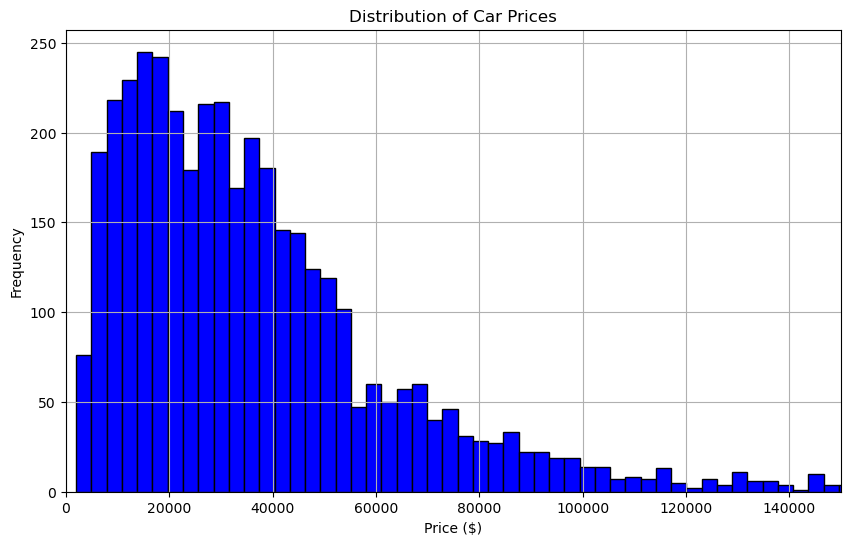

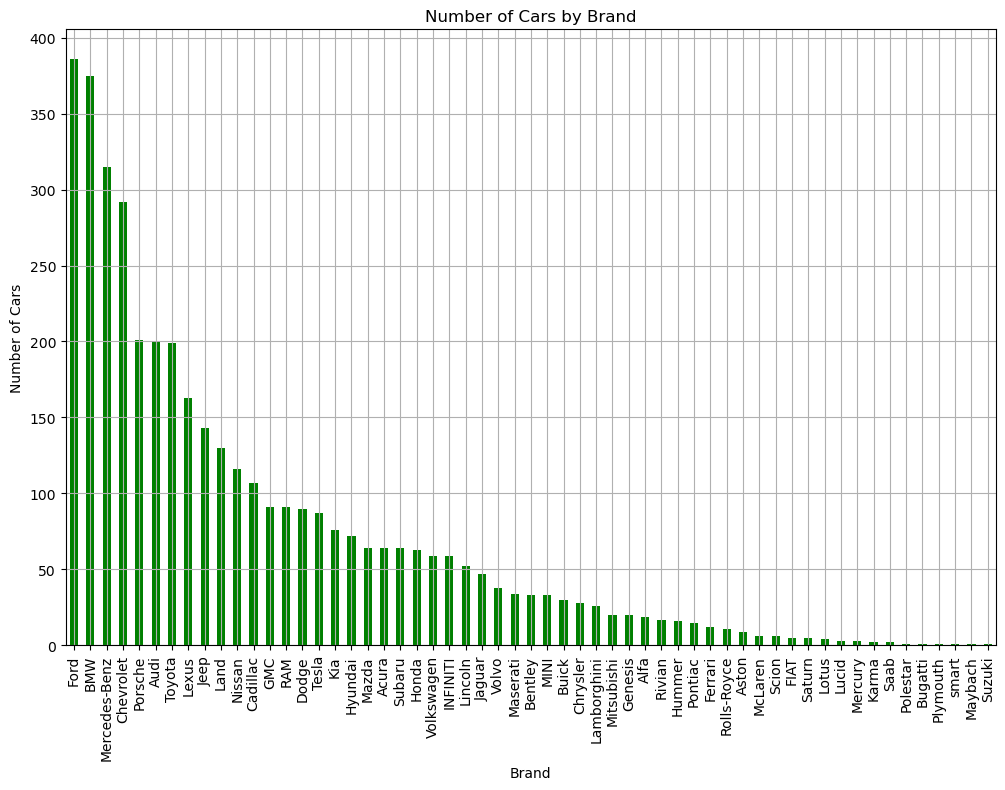

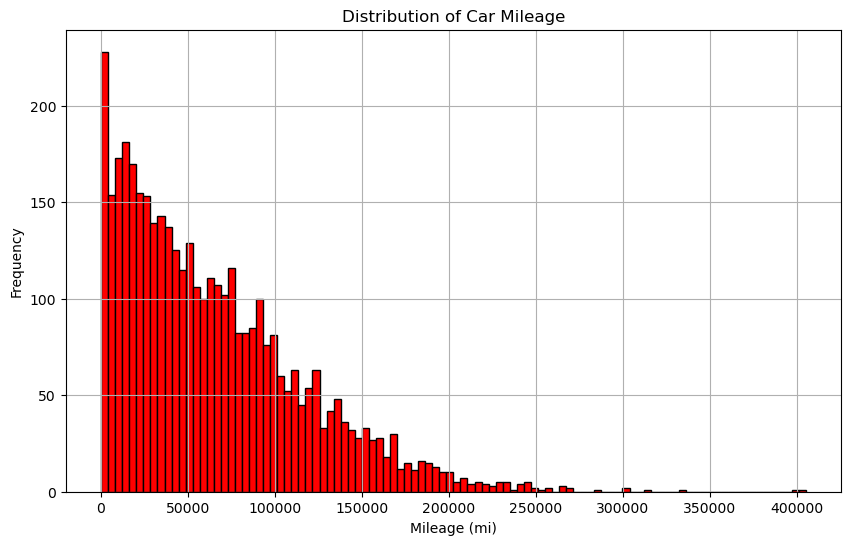

In [29]:
# Plot distribution of car prices
plt.figure(figsize=(10, 6))
plt.hist(dataset['price'].dropna(), bins=1000, color='blue', edgecolor='black')
plt.title('Distribution of Car Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(0,150000)
plt.show()


# Plot number of cars by brand
plt.figure(figsize=(12, 8))
dataset['brand'].value_counts().plot(kind='bar', color='green')
plt.title('Number of Cars by Brand')
plt.xlabel('Brand')
plt.ylabel('Number of Cars')
plt.grid(True)
plt.show()

# Plot distribution of mileage
plt.figure(figsize=(10, 6))
plt.hist(dataset['milage'].dropna(), bins=100, color='red', edgecolor='black')
plt.title('Distribution of Car Mileage')
plt.xlabel('Mileage (mi)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

origina_format = dataset.copy()

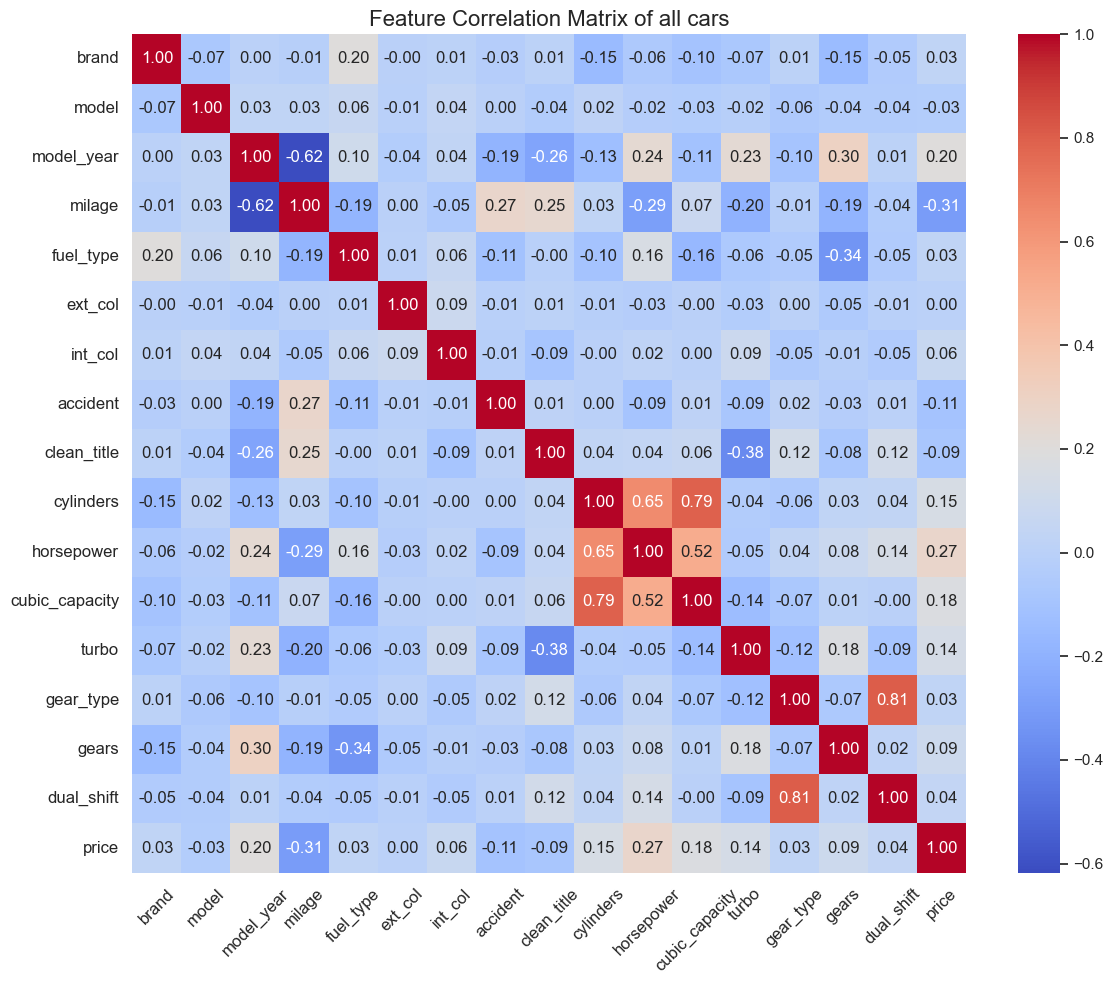

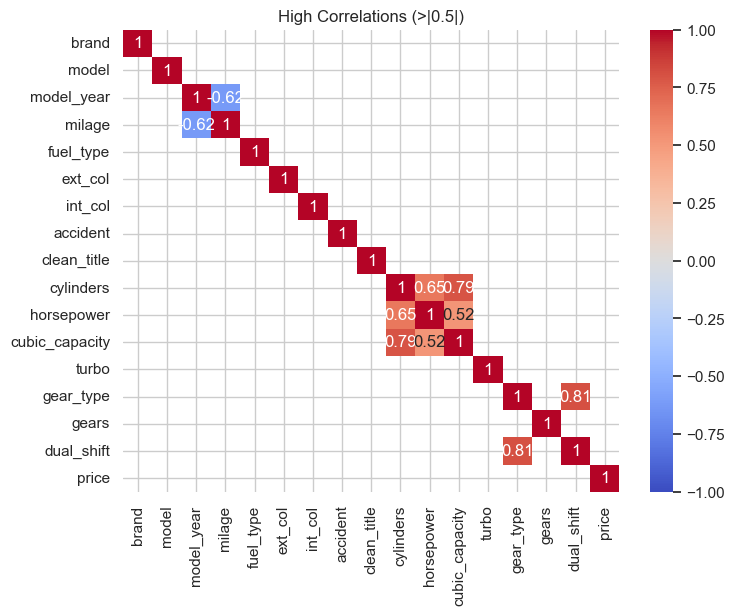

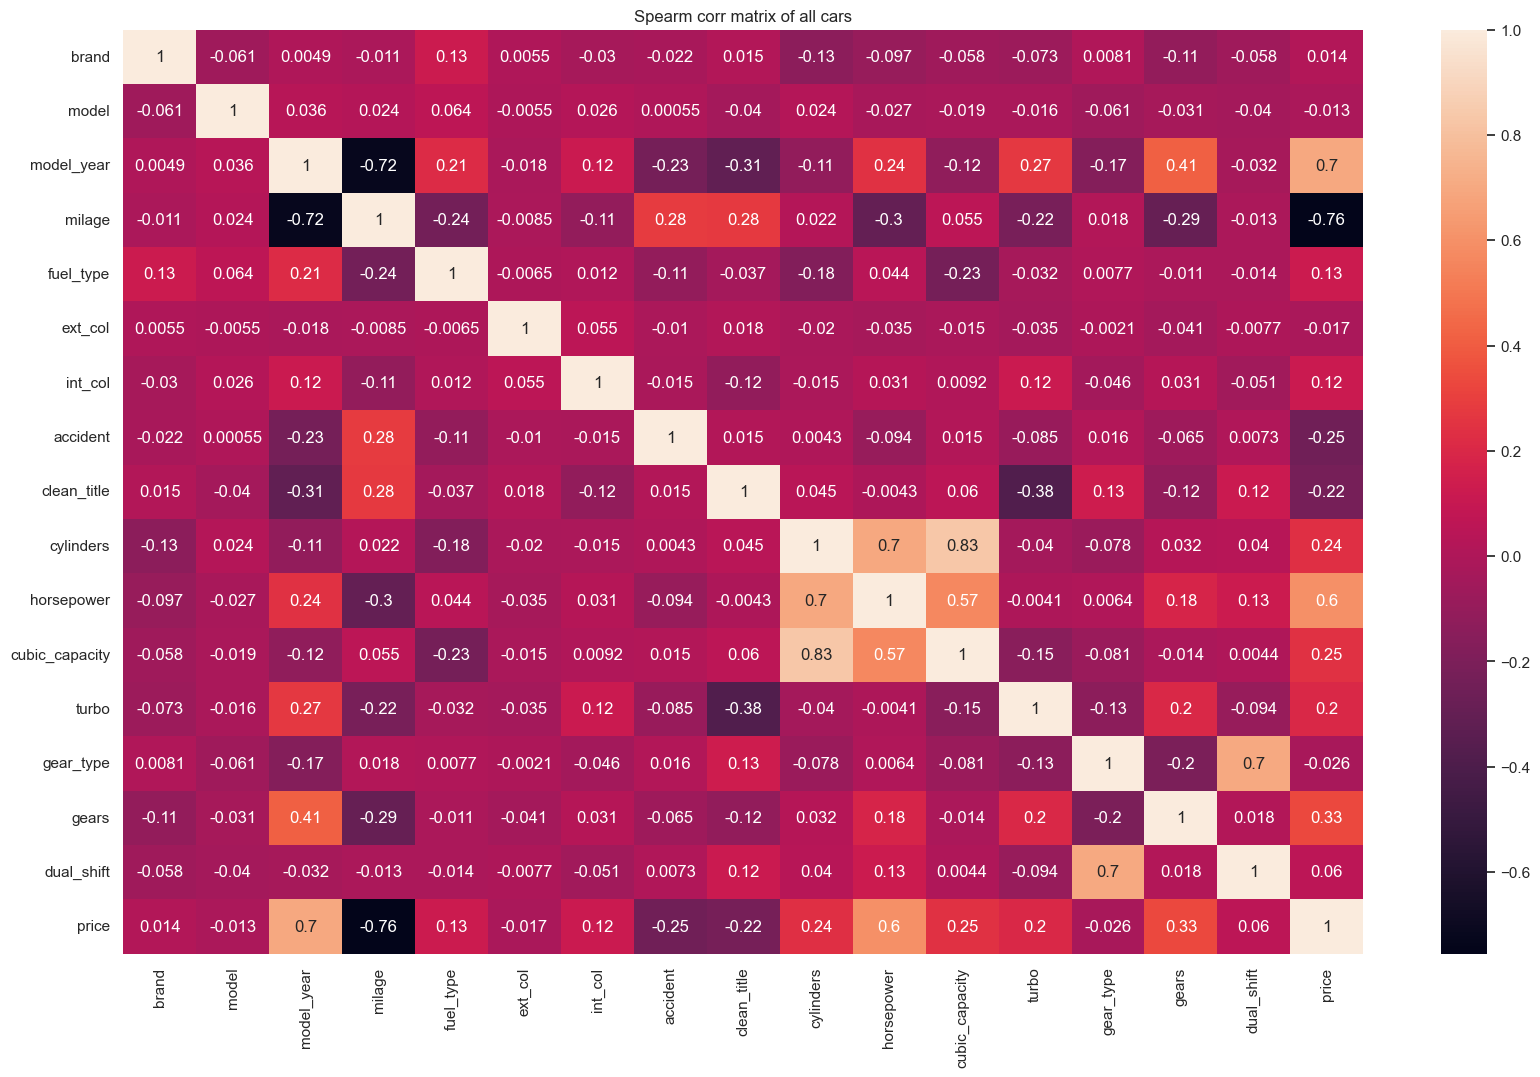

In [98]:
# Prepare data for models
dataset = dataset[[
    'brand',
    'model',
    'model_year',
    'milage',
    'fuel_type',
    'ext_col',
    'int_col',
    'accident',
    'clean_title',
    'cylinders',
    'horsepower',
    'cubic_capacity',
    'turbo',
    'gear_type',
    'gears',
    'dual_shift',
    'price'
]]
# Encode categorical variables using label encoding
label_encoders = {}
for column in dataset.select_dtypes(include=['object']).columns:
    label_encoders[column] = preprocessing.LabelEncoder()
    dataset[column] = label_encoders[column].fit_transform(dataset[column])
    dataset[column] = label_encoders[column].fit_transform(dataset[column])

# Correlation matrix
correlation_matrix = dataset.corr()
plt.figure(figsize=(12, 10))  # Adjust the width and height
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix of all cars', fontsize=16)  # Increase title font size
plt.xticks(fontsize=12, rotation=45)  # Adjust tick font size and rotate labels
plt.yticks(fontsize=12)
plt.tight_layout()  # Ensure everything fits
plt.show()

# Only high correlations above 0,5
threshold = 0.5
mask = np.abs(correlation_matrix) < threshold
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    mask=mask,
    cmap='coolwarm',
    cbar=True,
    vmin=-1, vmax=1
)
plt.title("High Correlations (>|0.5|)")
plt.show()

#Spearman alle 
corr = dataset.corr(method = 'spearman')
plt.figure(figsize=(20, 12))
sns.heatmap(corr, annot = True)
plt.title("Spearm corr matrix of all cars")
plt.show()

The attributes `dual_shift` and `gear_type` are highly correlated (seems like a lot of the transmissions have the same `dual_shift` and `gear_type` attribute in `transmission`), one of them should definitely be removed. Same goes for `cubic_capacity` and `cylinders`, which were derived from `engine`.

Spearman Correlation:
Highest: (0.5-1): Milage, Model_year, Horsepower
Medium (0.3-0.5):  Gears
Low (0.1-0.3): Cubic_Capacity, fuel_type, int_color, accident, clean_title, Turbo
Basically non-existent: brand, model, ext_color, gear_type, gear_shift 

## Train Test Fold Split

In [31]:
from sklearn.model_selection import KFold

# Define the features and target variable
X = dataset.drop(columns=['price'])
y = dataset['price']

# Define the number of folds
k = 5

# Initialize KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

     # Join X_train_fold and y_train_fold back into a single DataFrame
    train_set = pd.concat([X_train_fold, y_train_fold], axis=1)

print('X_train_fold shape:', X_train_fold.shape)
print('X_test_fold shape:', X_test_fold.shape)
print(X_train_fold)
print(train_set.isnull().sum(axis = 0))

X_train_fold shape: (3208, 16)
X_test_fold shape: (801, 16)
      brand  model  model_year    milage  fuel_type  ext_col  int_col  \
0        14   1743        2013   51000.0          1       29       14   
2        27   1325        2022   22372.0          2       38       14   
3        20   1242        2015   88900.0          3       29       14   
5         0    877        2016  136397.0          2      263       61   
6         3   1460        2017   84000.0          2       38       14   
...     ...    ...         ...       ...        ...      ...      ...   
4004      5    484        2023     714.0          2       50       75   
4005      3   1464        2022   10900.0          2       29       14   
4006     43   1677        2022    2116.0          7       29       14   
4007     14    666        2020   33000.0          2       38       14   
4008      4   1790        2020   43000.0          2      128       31   

      accident  clean_title  cylinders  horsepower  cubic_capac

EDA


In [32]:
train_set.isnull().sum(axis = 0)
train_set.describe()

,brand,model,model_year,milage,fuel_type,ext_col,int_col,accident,clean_title,cylinders,horsepower,cubic_capacity,turbo,gear_type,gears,dual_shift,price
count,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3.208000e+03
mean,23.649314,926.991584,2015.478180,64683.788342,2.231608,157.724751,40.033978,0.278990,0.849751,6.189526,326.708229,3.663155,0.072319,0.345387,6.922693,0.101621,4.523558e+04
std,16.407525,549.556828,6.136491,52182.551373,1.184416,112.385601,43.457628,0.448573,0.357371,1.480016,108.018071,1.376818,0.259056,0.692809,1.375407,0.302196,8.485289e+04
min,0.000000,0.000000,1974.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,70.000000,0.650000,0.000000,0.000000,1.000000,0.000000,2.000000e+03
25%,9.000000,479.750000,2012.000000,22476.500000,2.000000,36.000000,14.000000,0.000000,1.000000,6.000000,268.000000,2.500000,0.000000,0.000000,7.000000,0.000000,1.700000e+04
50%,21.000000,900.500000,2017.000000,53000.000000,2.000000,128.000000,14.000000,0.000000,1.000000,6.000000,310.000000,3.500000,0.000000,0.000000,7.000000,0.000000,3.100000e+04
75%,36.000000,1405.250000,2020.000000,94739.750000,2.000000,263.000000,71.000000,1.000000,1.000000,8.000000,381.000000,4.600000,0.000000,0.000000,7.000000,0.000000,4.990000e+04
max,56.000000,1897.000000,2024.000000,405000.000000,7.000000,318.000000,155.000000,1.000000,1.000000,12.000000,835.000000,8.400000,1.000000,2.000000,10.000000,1.000000,2.954083e+06


# Highlevel EDA of multiple attributes thought to be essential (by domain knowledge)

## Effect of model year and/or milage on price

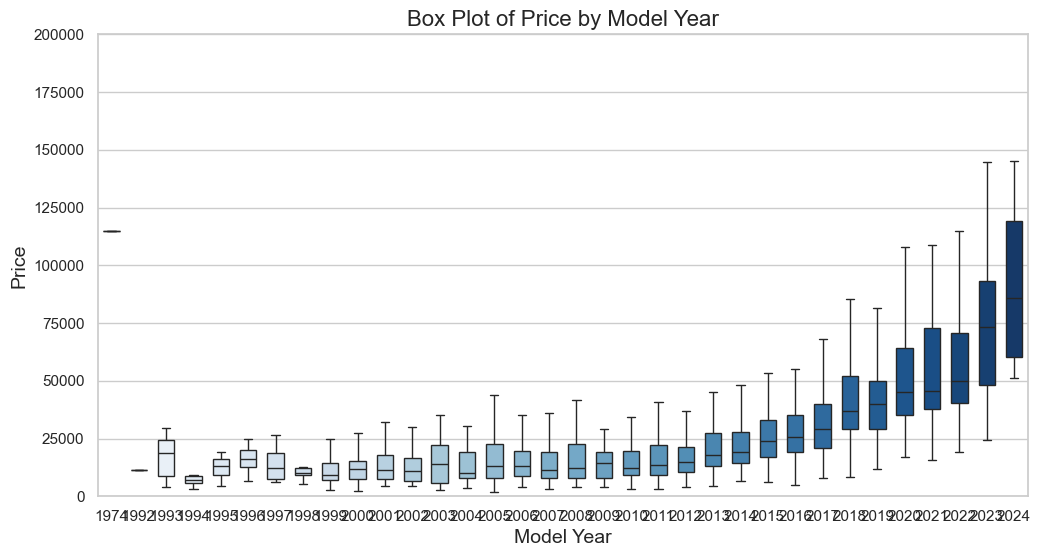

In [64]:

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='model_year', y='price', data=train_set, palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=train_set, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by Model Year', fontsize=16)
plt.xlabel('Model Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(train_set['model_year'].unique()), 5), labels=train_set['model_year'].unique()[::5])
plt.ylim(0,200000)
plt.show()




Here we can see that 1974 and 1997 are highly seperated. The distribution of the means (and in general boxplots) seems to show an exponential relationship. There is a price deep in 1998 and 1994 compared to their "neighbor years". In general the whiskers are quite wide. However, the older the vehicle, the smaller the whiskers but also smaller boxes. We can say that the prices in absolute terms are less spread the older the vehicle is. Thus, we can expect higher price prediction accuracy on older vehicles.

TODO: Hence, being able to reduce the variance of the cars or trying to find variables that explain the variance is vital.

TODO: One could think that cars before 2k are old timer. Now we will check how many data points are in those years to check if they are outliers, since their boxplot is very small.


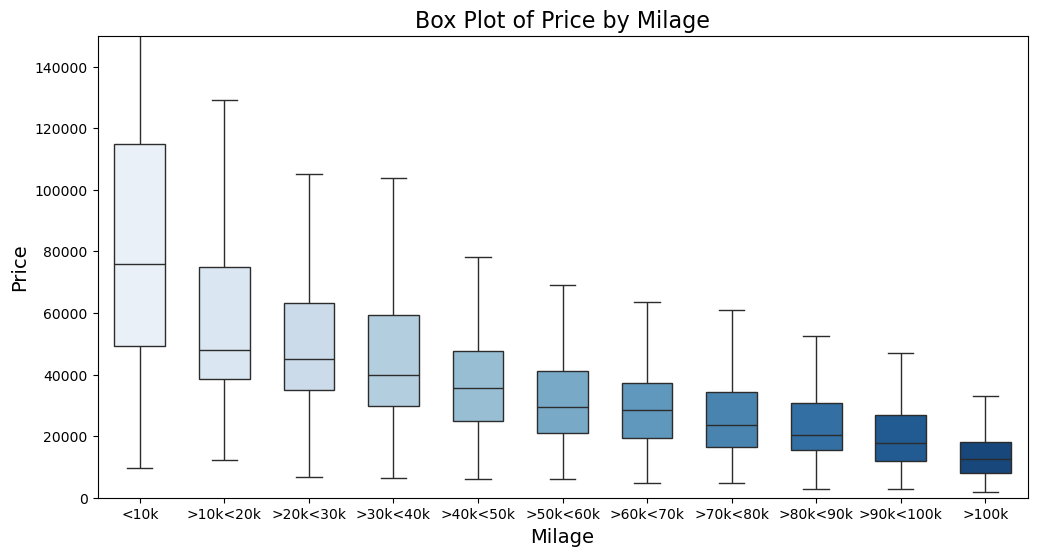

milage_Category
<10k         114999.50
>10k<20k      75000.00
>20k<30k      63249.50
>30k<40k      59400.75
>40k<50k      47483.50
>50k<60k      41249.50
>60k<70k      37352.50
>70k<80k      34375.00
>80k<90k      30868.75
>90k<100k     27000.00
>100k         18100.00
Name: price, dtype: float64


In [34]:
# Define the bins for the Mileage categories
mileage_bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, float('inf')]
mileage_labels = ['<10k', '>10k<20k', '>20k<30k', '>30k<40k', '>40k<50k', '>50k<60k', '>60k<70k', '>70k<80k', '>80k<90k', '>90k<100k', '>100k']

# Create the Mileage categories
train_set['milage_Category'] = pd.cut(train_set['milage'], bins=mileage_bins, labels=mileage_labels, right=False)



# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='milage_Category', y='price', data=train_set, palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=train_set, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by Milage', fontsize=16)
plt.xlabel('Milage', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(train_set['model_year'].unique()), 5), labels=train_set['model_year'].unique()[::5])
plt.ylim(0,150000)
plt.show()
# Calculate the 75th percentile for price in each Mileage Category
percentile_75 = train_set.groupby('milage_Category')['price'].quantile(0.75)

# Print the 75th percentile for each category
print(percentile_75)

## Checking if attributes change in relevanz for cars newer than 2010 (based on observation of variance)

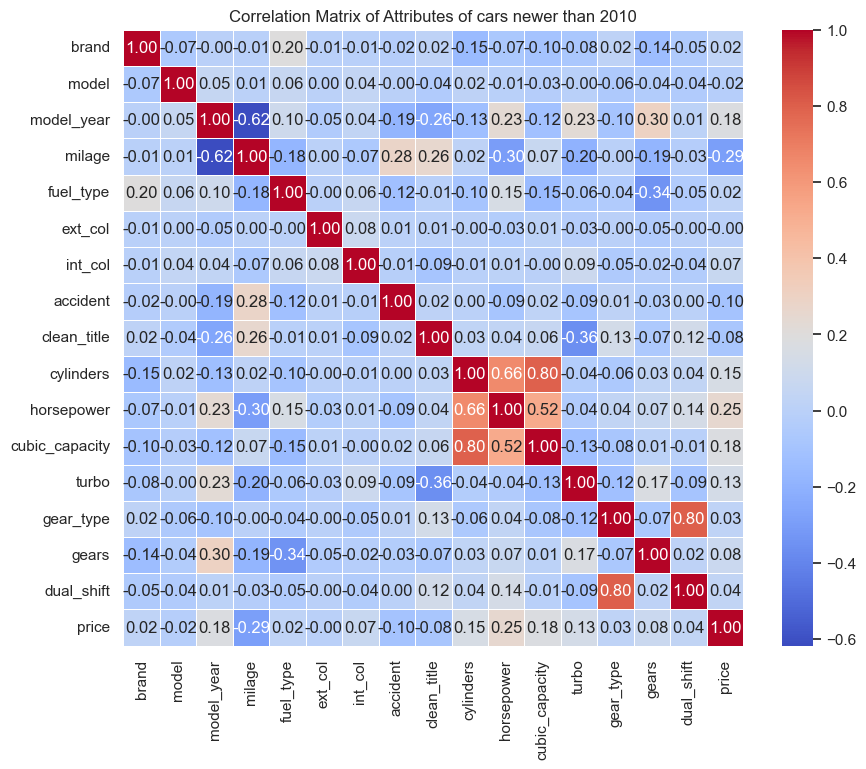

In [97]:
# Correlation matrix for cars newer than 2010
train_set_age = train_set.copy()
train_set_age["age"] = 2024 - train_set["model_year"]
# Get the position of the 'price' column (last column)
price_column_index = train_set_age.columns.get_loc("price")

# Insert 'age' column just before the 'price' column
train_set_age.insert(price_column_index, "age", train_set_age.pop("age"))
new_cars = train_set.copy()
corr_matrix = new_cars.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Attributes of cars newer than 2010')
plt.show()

In [44]:
# Find the lowest price for each model year
lowest_price_by_year = train_set.groupby('model_year')['price'].min().reset_index()

lowest_price_by_year
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3208 entries, 0 to 4008
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   brand           3208 non-null   int64  
 1   model           3208 non-null   int64  
 2   model_year      3208 non-null   int64  
 3   milage          3208 non-null   float64
 4   fuel_type       3208 non-null   int64  
 5   ext_col         3208 non-null   int64  
 6   int_col         3208 non-null   int64  
 7   accident        3208 non-null   int64  
 8   clean_title     3208 non-null   int64  
 9   cylinders       3208 non-null   float64
 10  horsepower      3208 non-null   float64
 11  cubic_capacity  3208 non-null   float64
 12  turbo           3208 non-null   int64  
 13  gear_type       3208 non-null   int64  
 14  gears           3208 non-null   float64
 15  dual_shift      3208 non-null   int64  
 16  price           3208 non-null   float64
dtypes: float64(6), int64(11)
memory usage:

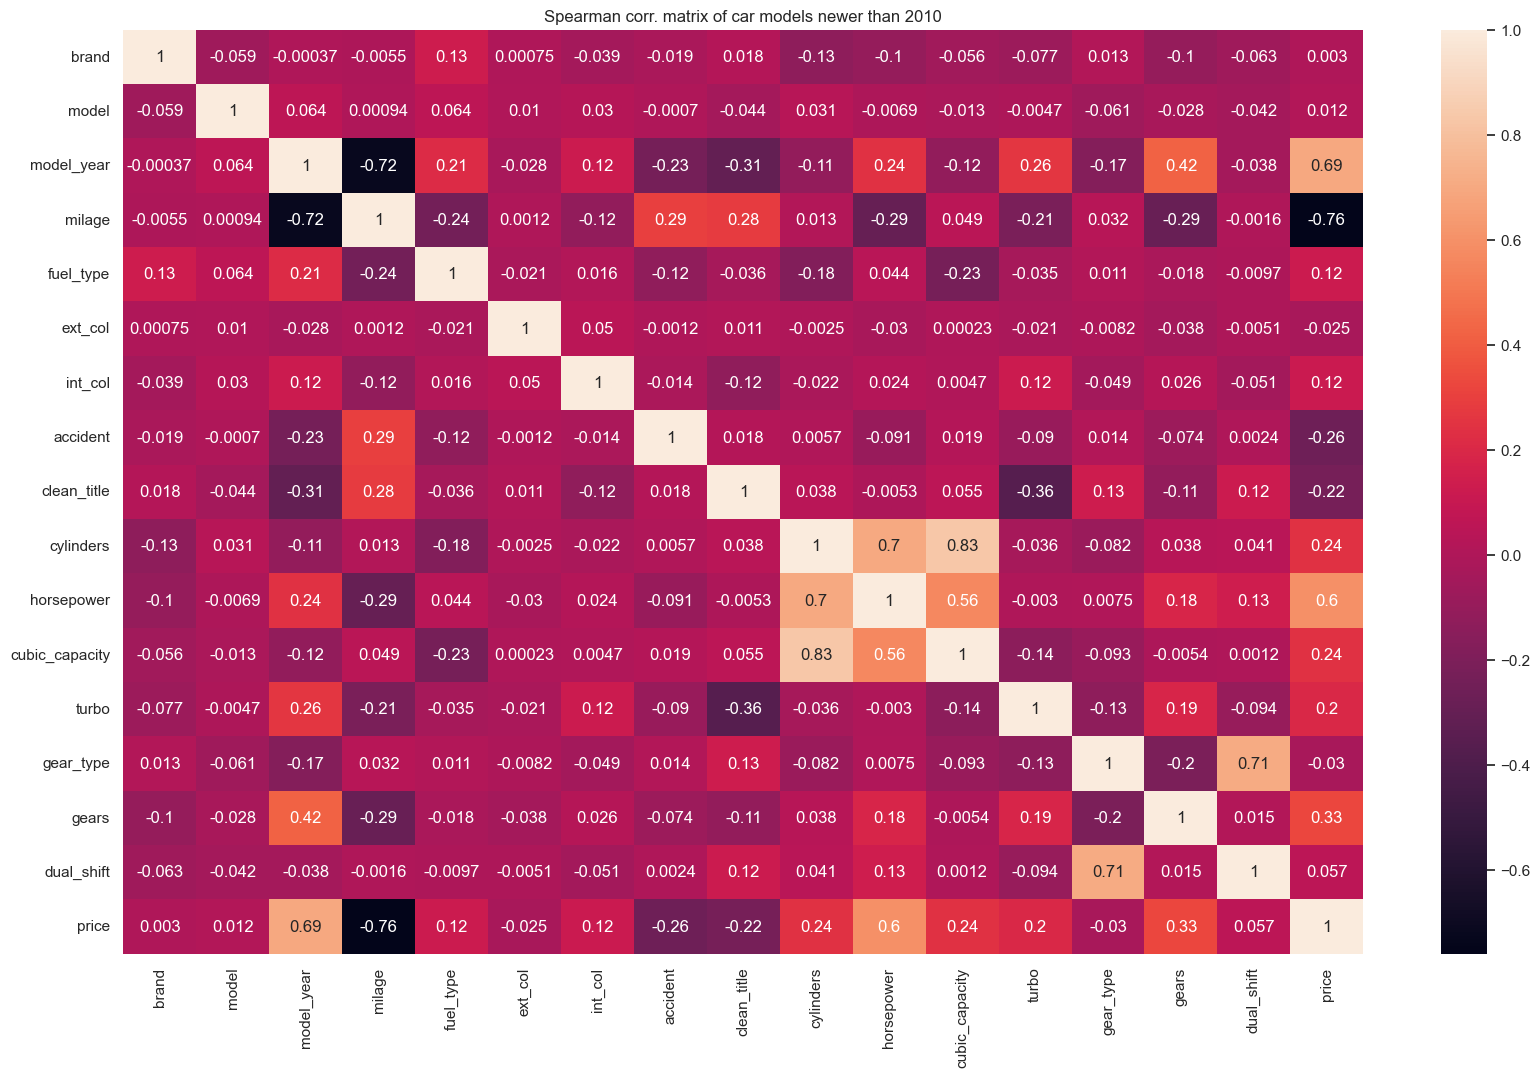

In [96]:
#Spearman alle 
corr = new_cars.corr(method = 'spearman')
plt.figure(figsize=(20, 12))
sns.heatmap(corr, annot = True)
plt.title("Spearman corr. matrix of car models newer than 2010")
plt.show()

Barely changes in correlations. TODO: Hypothesis: Price split at that point because milage starts to vary highly at that point

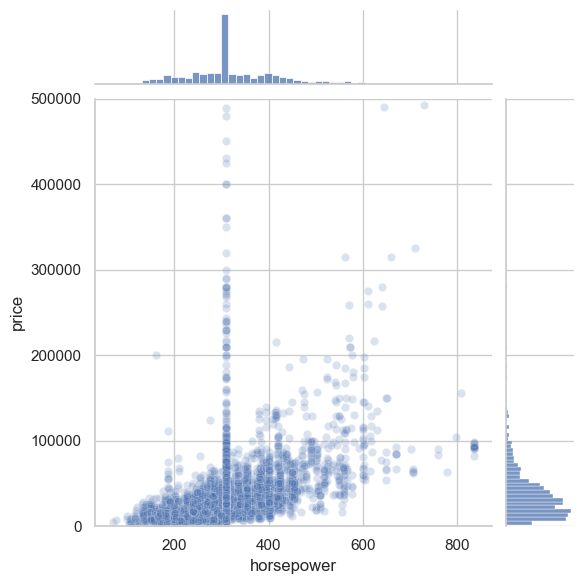

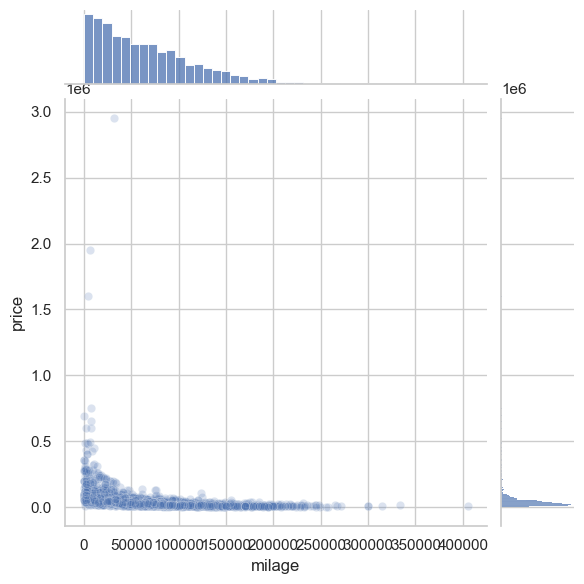

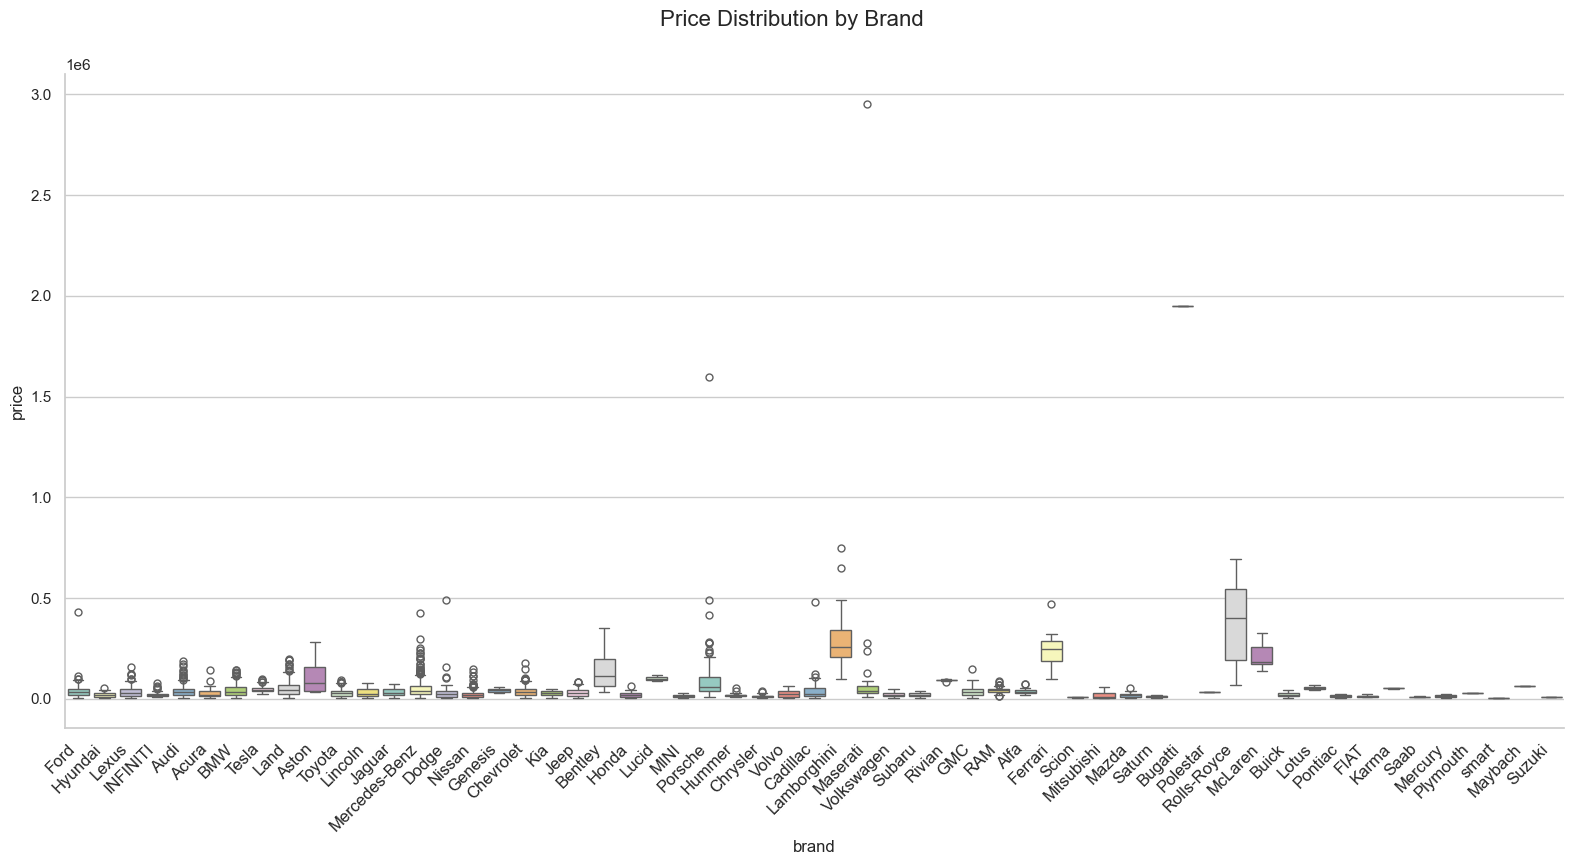

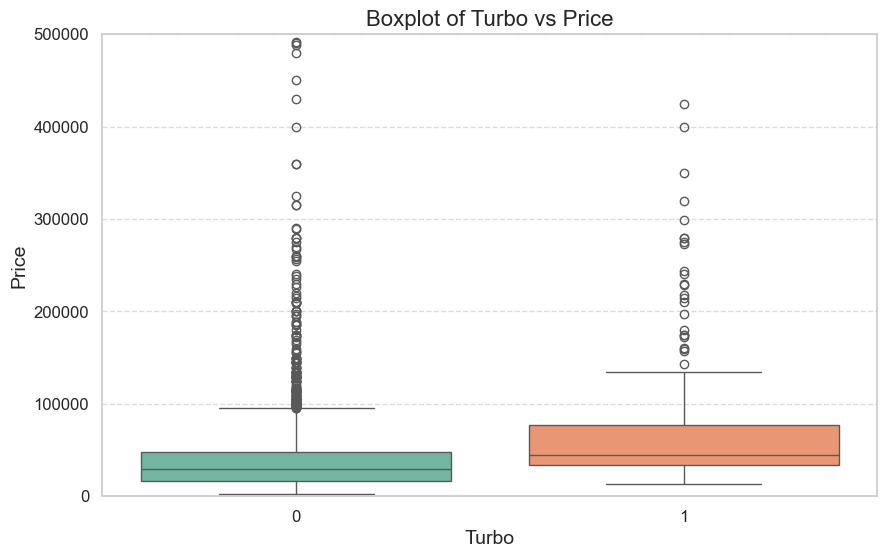

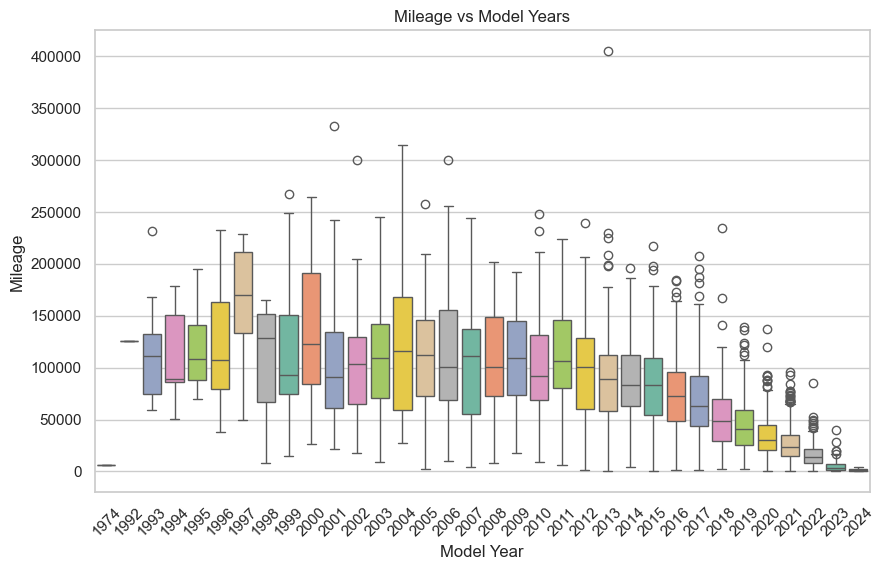

In [99]:
sns.jointplot(x="horsepower", y="price", data=train_set, alpha=0.2, ylim= (0,500000))
sns.jointplot(x="milage", y="price", data=train_set, alpha=0.2)
# Use catplot to visualize brand vs price
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=origina_format, 
    x="brand", y="price", 
    kind="box", 
    height=8, aspect=2,  # Adjust height and aspect ratio
    palette="Set3"
)

# Rotate x-axis labels for readability
g.set_xticklabels(rotation=45, ha="right", fontsize=12)

# Enhance the plot
g.fig.subplots_adjust(top=0.9)  # Adjust top space for title
g.fig.suptitle("Price Distribution by Brand", fontsize=16)
plt.show()
# Boxplot of turbo vs price
plt.figure(figsize=(10, 6))
sns.boxplot(x="turbo", y="price", data=train_set, palette="Set2")

# Enhance the plot
plt.title("Boxplot of Turbo vs Price", fontsize=16)
plt.xlabel("Turbo", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,500000)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Filter to show only every 5th year
filtered_data = train_set

# Boxplot with fewer years
plt.figure(figsize=(10, 6))
sns.boxplot(x="model_year", y="milage", data=filtered_data, palette="Set2")

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.title("Mileage vs Model Years")
plt.xlabel("Model Year")
plt.ylabel("Mileage")

plt.show()


We can see that there are a lot of potential outliers when determining the price of a car based on its brand. It seems like some brands are usually more expensive than others like Aston, Bentley, Porsche, Lambourghini, Ferrrari, MCLaren and Rolse-Royce. Mercedes-Benz has plenty of cars that are priced high which are indicated as pot outliers. However, MB has a wide portfolio, from afforable to luxury cars. Interestingly, Maserati isnt part of the higher priced cars. In gerneral, we can see that brands that (mainly) offer luxury products are higher priced. TODO: Potentially we can use this as an attribute in feature engineering.
Furthermore, we find that  cars are usually more expensive when they have a turbo. However, these also have plenty of pot. outliers. TODO: It would be interesting to see what attribues make the cars be outliers.
We can also see an unusual spike in amount of cars and price at the 300 horsepower mark. It reminds of a steep normal distribution. Horsepower has a positive relationship with price, however, the variance is large, indicating there are more important variables to be considered (in parallel). After the 300 HP mark, the variance of HP-price significantly increases. Indicating that there are other attributes that are more important at that point.
It seems like the hypothesis regarding the increase in variance of price since 2010 is true: The Median decreases, whereby in earlier years it stays steady or goes up

# Examining the differnece luxury cars make in prices -> Creating appropriate attributes

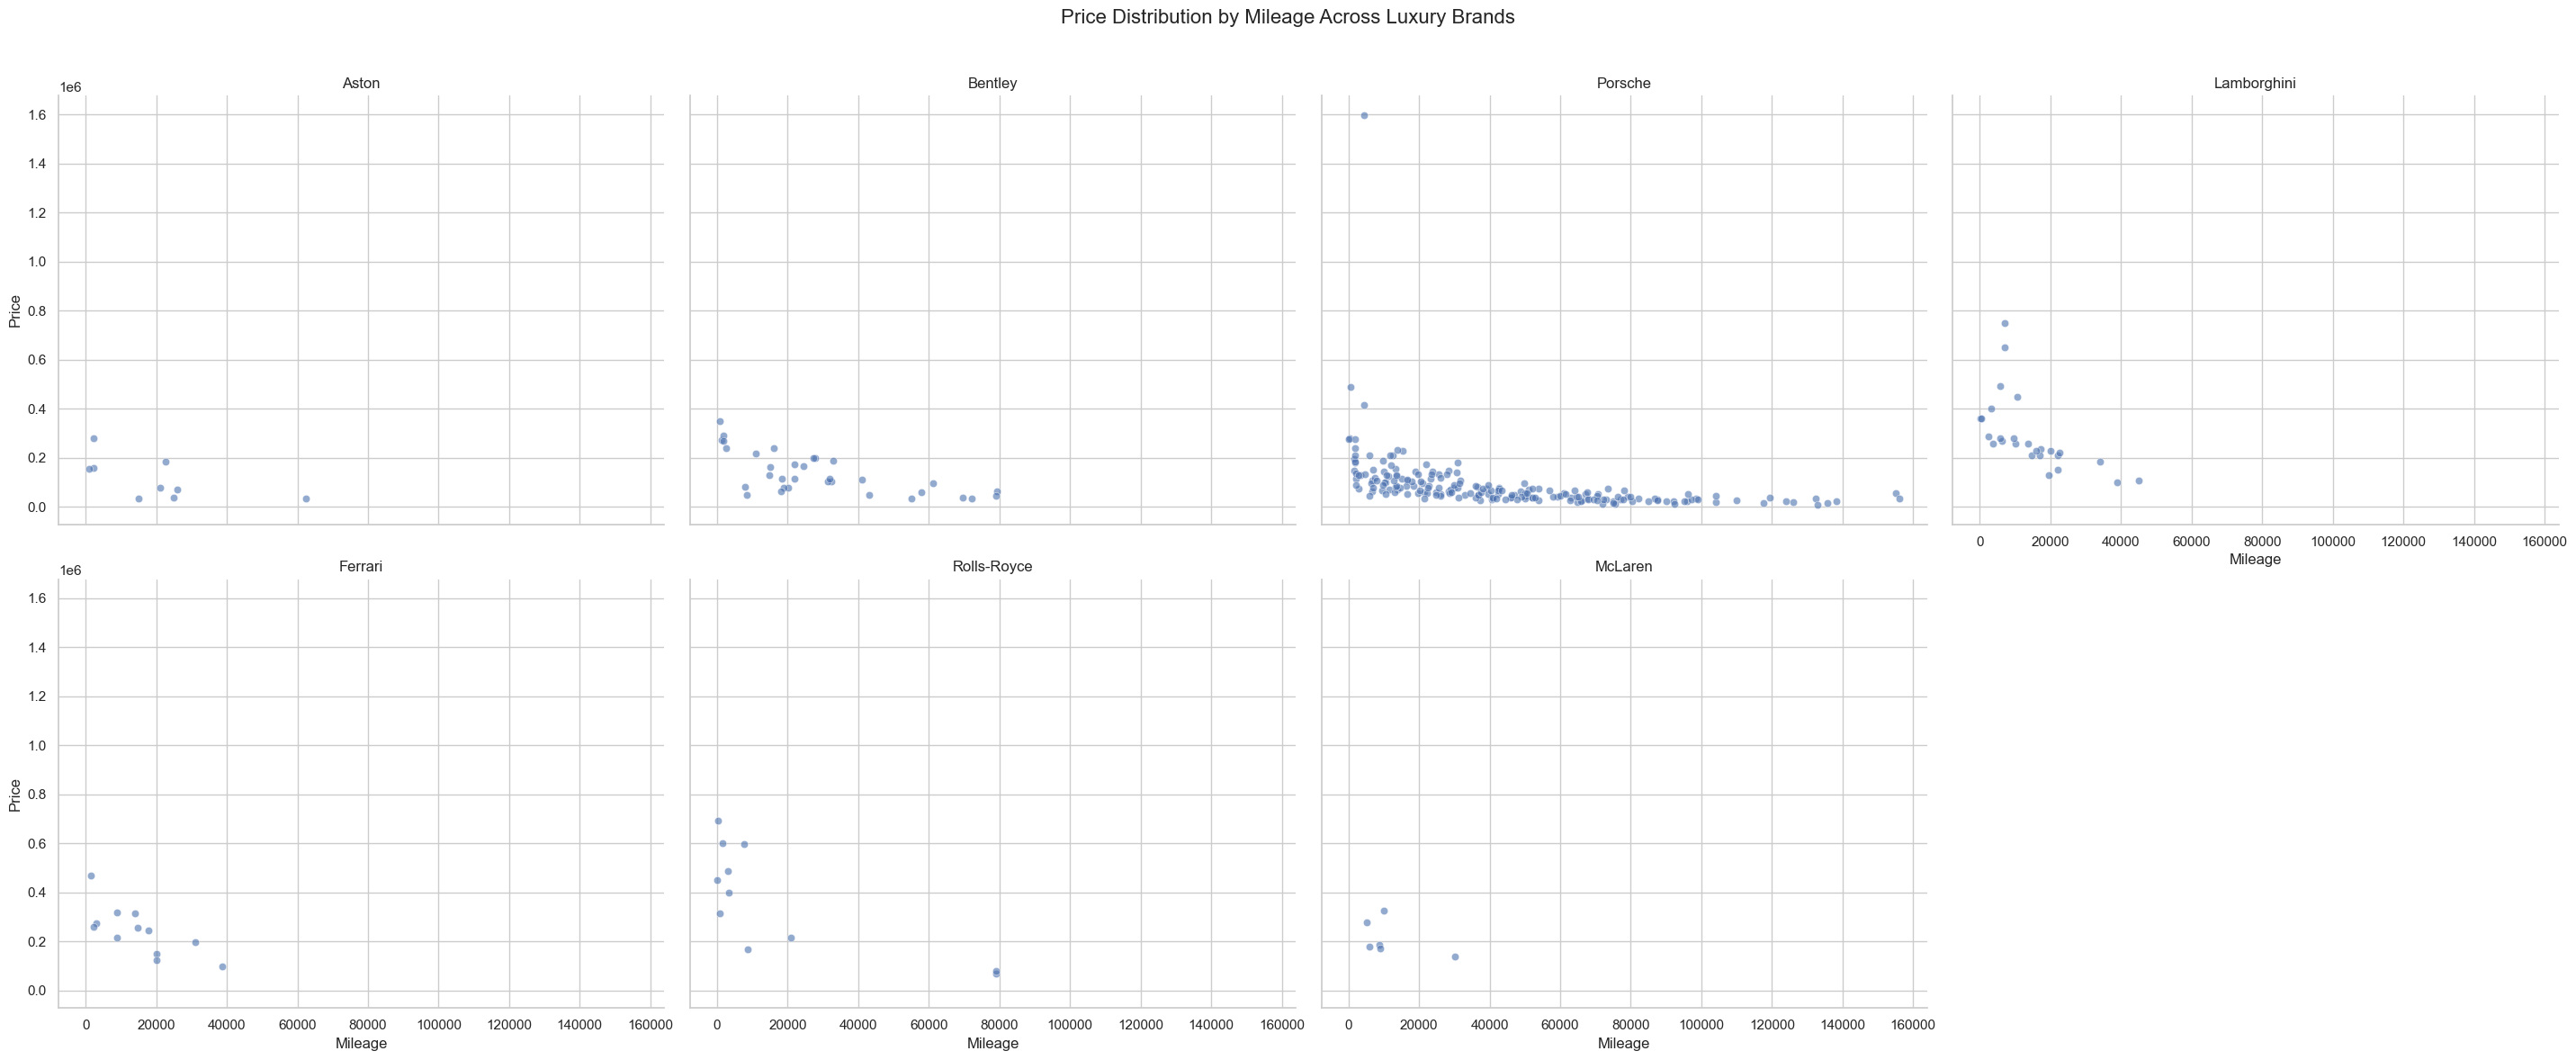

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data to include only the specified brands
luxury_brands = ["Aston", "Bentley", "Porsche", "Lamborghini", "Ferrari", "McLaren", "Rolls-Royce"]
filtered_data = origina_format[origina_format["brand"].isin(luxury_brands)]

# Create the FacetGrid for Mileage vs Price
g = sns.FacetGrid(filtered_data, col="brand", col_wrap=4, height=6, aspect=1.2)
g.map_dataframe(sns.scatterplot, x="milage", y="price", alpha=0.6)

# Adjust labels and title
g.set_axis_labels("Mileage", "Price")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)  # Adjust top space
g.fig.suptitle("Price Distribution by Mileage Across Luxury Brands", fontsize=16)

# Show plot
plt.show()


Although, the correlations matrices (spearmann and pearson) indicate that brand isnt correlated with the price, we can see that it is still an important factor in dterming the price. For example, a vehicle with a milage of 40k from Toyota is priced from around 10k-70k, most of them being around 40k. Cars with the same milage of the brand Porsche, on the other hand, are around the 100-130k price tag. This is a difference of factor 2 to 3. Thus, we need to create attributes that differentiate these types of cars from the others so the model hopefully has a easier time determining car prices

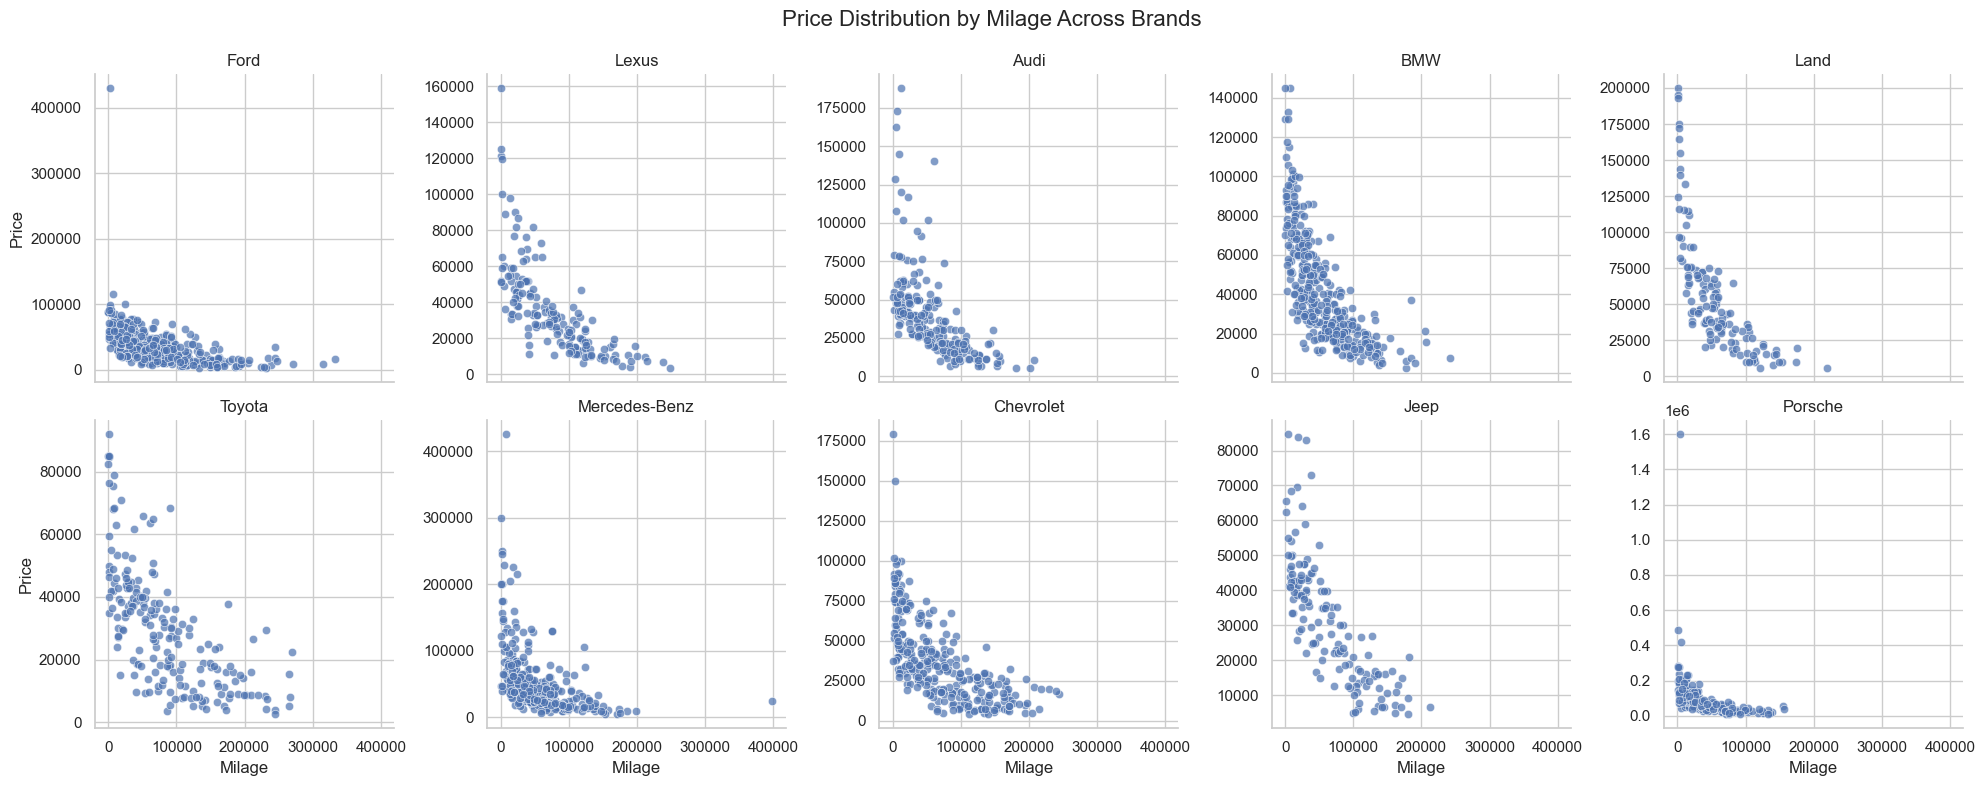

In [49]:
# Limit to top 10 brands and drop rows with missing prices
filtered_data = origina_format.dropna(subset=['price'])
top_brands = filtered_data['brand'].value_counts().nlargest(10).index
filtered_data = filtered_data[filtered_data['brand'].isin(top_brands)]

# Create a FacetGrid
g = sns.FacetGrid(filtered_data, col="brand", col_wrap=5, height=4, sharey=False)
g.map_dataframe(sns.scatterplot, x="milage", y="price", alpha=0.7)

# Add titles and labels
g.set_axis_labels("Milage", "Price")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Price Distribution by Milage Across Brands", fontsize=16)

plt.show()

The plot(s) shows that the value of cars is negativly impacted by the milage. However, some brands aren't as susceptible to this reducation as others. For example, 

In [50]:
# Calculate the number of cars with over 80,000 miles
df_over_80k = origina_format[origina_format['price'] > 80000]

# Calculate the relative amount
relative_amount = df_over_80k.groupby('brand').size() / df.groupby('brand').size()
relative_amount = relative_amount[~np.isnan(relative_amount)]


# Calculate the absolute amount
absolute_amount = df_over_80k.groupby('brand').size()
absolute_amount = absolute_amount[~np.isnan(absolute_amount)]


# Combine both results into a single dataframe
result = pd.concat([relative_amount, absolute_amount], axis=1)
result.columns = ['Relative', 'Absolute']
result = result.sort_values(by="Relative", ascending=False)
# Print the result
print(result)


               Relative  Absolute
brand                            
Lamborghini    1.000000        26
Ferrari        1.000000        12
McLaren        1.000000         6
Lucid          1.000000         3
Rivian         1.000000        17
Bugatti        1.000000         1
Rolls-Royce    0.909091        10
Bentley        0.666667        22
Aston          0.444444         4
Porsche        0.353234        71
Maserati       0.176471         6
Land           0.169231        22
Cadillac       0.158879        17
Mercedes-Benz  0.158730        50
BMW            0.104000        39
Tesla          0.068966         6
Chevrolet      0.068493        20
Lexus          0.067485        11
GMC            0.065934         6
Audi           0.065000        13
Dodge          0.044444         4
Nissan         0.043103         5
Ford           0.033679        13
Acura          0.031250         2
Toyota         0.025126         5
RAM            0.021978         2
Jeep           0.020979         3


In [51]:
# Define the bins for the Mileage categories
mileage_bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, float('inf')]
mileage_labels = ['<10k', '>10k<20k', '>20k<30k', '>30k<40k', '>40k<50k', '>50k<60k', '>60k<70k', '>70k<80k', '>80k<90k', '>90k<100k', '>100k']

# Create the Mileage categories
origina_format['milage_Category'] = pd.cut(origina_format['milage'], bins=mileage_bins, labels=mileage_labels, right=False)

# Calculate the 75th percentile for price in each Mileage Category
percentile_75 = origina_format.groupby('milage_Category')['price'].quantile(0.75)

# Function to filter cars above the 75th percentile for each brand
def filter_above_percentile(df, percentile_75):
    results = []
    
    for category, threshold in percentile_75.items():
        # Filter cars with Price > 75th percentile for the given category
        filtered = df[(df['milage_Category'] == category) & (df['price'] > threshold)]
        
        # Calculate absolute and relative counts for each brand
        absolute_count = filtered.groupby('brand').size()
        total_count = df[df['milage_Category'] == category].groupby('brand').size()
        relative_count = absolute_count / total_count
        
        # Store results
        for brand in absolute_count.index:
            results.append({
                'brand': brand,
                'milage_Category': category,
                'Absolute_Above_75th': absolute_count[brand],
                'Relative_Above_75th': relative_count[brand]
            })
    
    return pd.DataFrame(results)

# Filter and calculate the results
filtered_results = filter_above_percentile(origina_format, percentile_75)
# Calculate the average of `Relative_Above_75th` for each Mileage Category
category_avg = filtered_results.groupby('brand')['Relative_Above_75th'].mean()

# Filter categories where the average is greater than 0.8 (80%)
categories_above_80_percent = category_avg[category_avg > 0.8].to_frame()
print(categories_above_80_percent)

# Filter categories where the average is greater than 0.8 (80%)
categories_above_50_below_80_percent = category_avg[(category_avg > 0.5) & (category_avg < 0.8)].to_frame()
print(categories_above_50_below_80_percent)


             Relative_Above_75th
brand                           
Aston                   0.875000
Bentley                 0.821429
Bugatti                 1.000000
Ferrari                 1.000000
Lamborghini             1.000000
Maybach                 1.000000
McLaren                 1.000000
Rolls-Royce             1.000000
         Relative_Above_75th
brand                       
Hummer              0.607143
Porsche             0.584974
RAM                 0.517681
Tesla               0.609368


Emils Feature engineering: We create 2 more attribues called "Is_Luxury" and "Is_Upper_class". The former are brands which cars are above the 75th percentile 80% of the time. The later below 80% and above 50% of the time. The rest are considered to be normal.

In [71]:
luxury_brands = categories_above_80_percent.index.tolist()
upper_class_brands = categories_above_50_below_80_percent.index.tolist()

# Add the 'Is_Luxury' column: 1 if the brand is in the luxury list, otherwise 0
origina_format['Is_Luxury'] = np.where(origina_format['brand'].isin(luxury_brands), 1, 0)
origina_format['Is_Upper_class'] = np.where(origina_format['brand'].isin(upper_class_brands), 1, 0)


origina_format["age"] = 2024 - origina_format["model_year"]

# Define the conditions and corresponding values
conditions = [
    origina_format["Is_Luxury"] == 1,  # If Is_Luxury is 1
    origina_format["Is_Upper_class"] == 1  # If Is_Upper_class is 1
]

# Define the corresponding values for each condition
values = [2, 1]  # 2 for Is_Luxury=1, 1 for Is_Upper_class=1

# Add the 'luxury_type' column based on the conditions
origina_format["luxury_type"] = np.select(conditions, values, default=0)

origina_format

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,cubic_capacity,turbo,gear_type,gears,dual_shift,milage_Category,Is_Luxury,Is_Upper_class,age,luxury_type
0,Ford,Utility Police Interceptor Base,2013,51000.0,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,1,...,3.7,0,Automatic,6.0,0,>50k<60k,0,0,11,0
1,Hyundai,Palisade SEL,2021,34742.0,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,1,...,3.8,0,Automatic,8.0,0,>30k<40k,0,0,3,0
2,Lexus,RX 350 RX 350,2022,22372.0,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,0,...,3.5,0,Automatic,7.0,0,>20k<30k,0,0,2,0
3,INFINITI,Q50 Hybrid Sport,2015,88900.0,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,0,...,3.5,0,Automatic,7.0,0,>80k<90k,0,0,9,0
4,Audi,Q3 45 S line Premium Plus,2021,9835.0,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,0,...,2.0,1,Automatic,8.0,0,<10k,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4004,Bentley,Continental GT Speed,2023,714.0,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,C / C,Hotspur,0,...,6.0,1,Automatic,8.0,0,<10k,1,0,1,2
4005,Audi,S4 3.0T Premium Plus,2022,10900.0,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,0,...,3.0,0,N/A,7.0,1,>10k<20k,0,0,2,0
4006,Porsche,Taycan,2022,2116.0,NaN,Electric,Automatic,Black,Black,0,...,3.5,0,Automatic,7.0,0,<10k,0,1,2,1
4007,Ford,F-150 Raptor,2020,33000.0,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,0,...,3.5,0,Automatic,7.0,0,>30k<40k,0,0,4,0


Now lets compare the boxplot from earlier to boxplots filtered on the new features

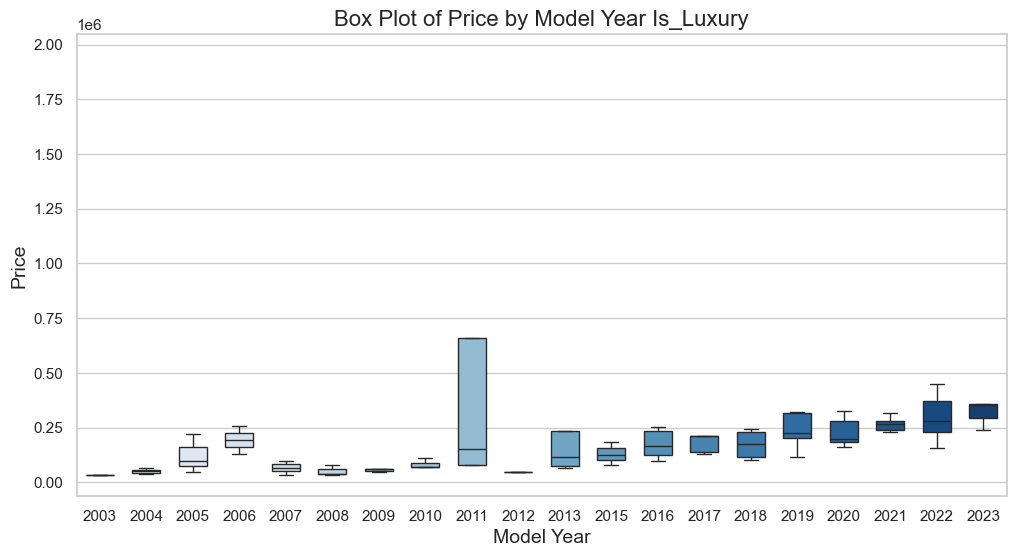

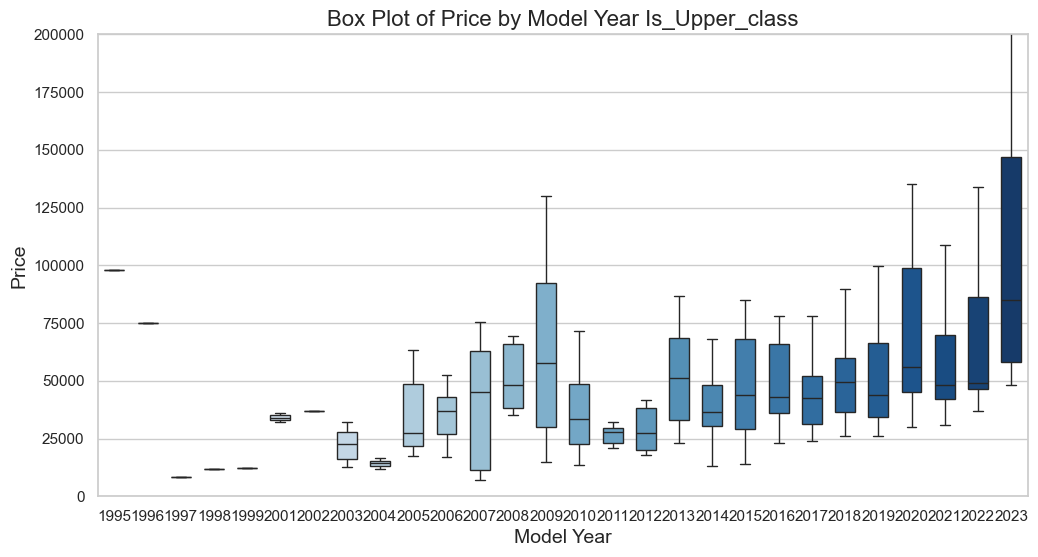

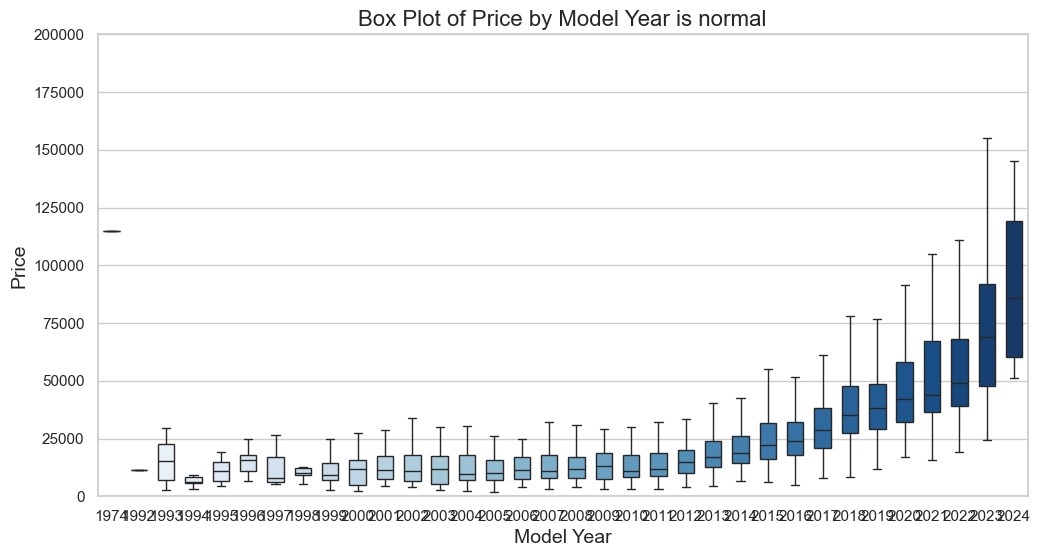

In [65]:
# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='model_year', y='price', data=origina_format[origina_format["Is_Luxury"] == 1], palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=train_set, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by Model Year Is_Luxury', fontsize=16)
plt.xlabel('Model Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(train_set['model_year'].unique()), 5), labels=train_set['model_year'].unique()[::5])
plt.show()

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='model_year', y='price', data=origina_format[origina_format["Is_Upper_class"] == 1], palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=train_set, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by Model Year Is_Upper_class', fontsize=16)
plt.xlabel('Model Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(train_set['model_year'].unique()), 5), labels=train_set['model_year'].unique()[::5])
plt.ylim(0,200000)
plt.show()

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='model_year', y='price', data=origina_format[(origina_format["Is_Upper_class"] == 0) & (origina_format["Is_Luxury"] == 0)], palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=train_set, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by Model Year is normal', fontsize=16)
plt.xlabel('Model Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(train_set['model_year'].unique()), 5), labels=train_set['model_year'].unique()[::5])
plt.ylim(0,200000)
plt.show()

There are large differences between the Box plots indicating that the seperation through the new attribute is helpful. When comparing the boxplot containing only normal cars with the plot with all, we can barely see a difference however. This can be explained by the number of cars represented by the class luxury or normal class. Since most of the cars are normal this leads to the box plot containing all cars converging with the one with only normal cars. 

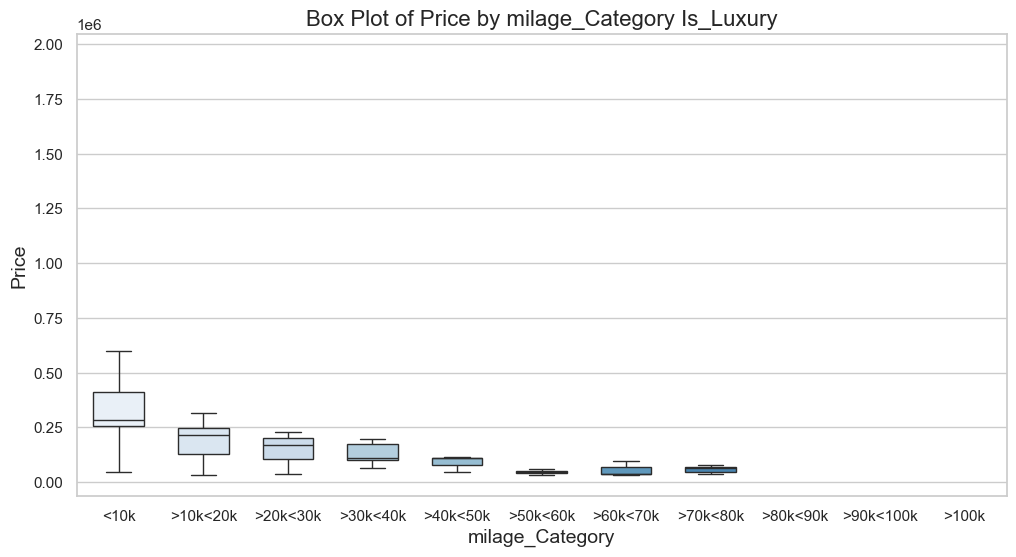

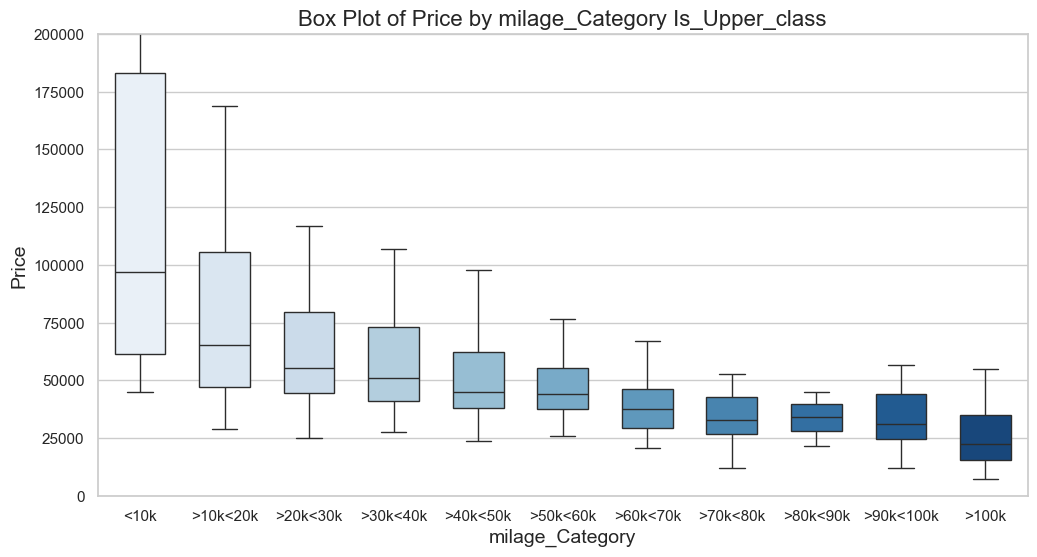

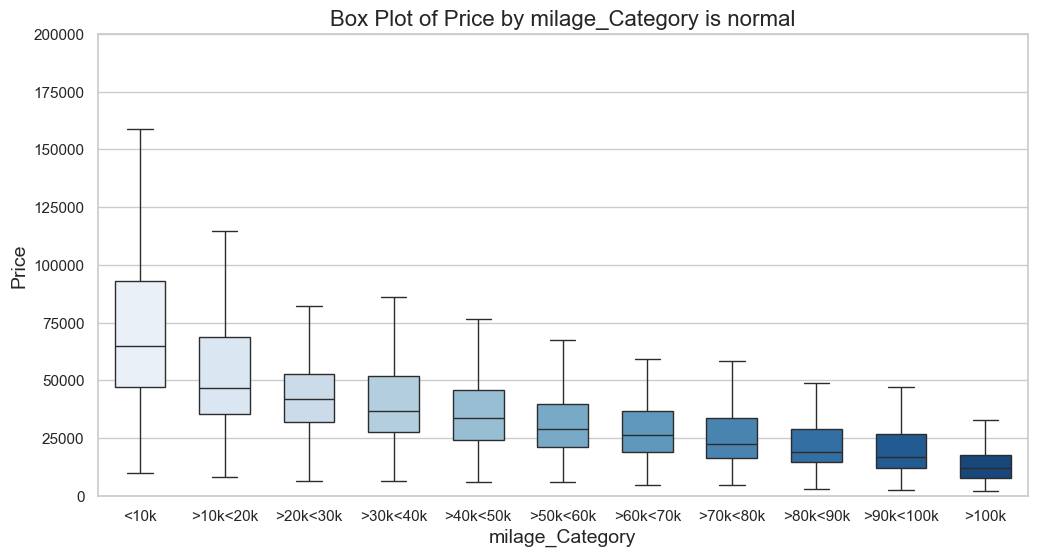

In [66]:
# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='milage_Category', y='price', data=origina_format[origina_format["Is_Luxury"] == 1], palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=train_set, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by milage_Category Is_Luxury', fontsize=16)
plt.xlabel('milage_Category', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(train_set['model_year'].unique()), 5), labels=train_set['model_year'].unique()[::5])
plt.show()

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='milage_Category', y='price', data=origina_format[origina_format["Is_Upper_class"] == 1], palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=train_set, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by milage_Category Is_Upper_class', fontsize=16)
plt.xlabel('milage_Category', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(train_set['model_year'].unique()), 5), labels=train_set['model_year'].unique()[::5])
plt.ylim(0,200000)
plt.show()

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='milage_Category', y='price', data=origina_format[(origina_format["Is_Upper_class"] == 0) & (origina_format["Is_Luxury"] == 0)], palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=train_set, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by milage_Category is normal', fontsize=16)
plt.xlabel('milage_Category', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(train_set['model_year'].unique()), 5), labels=train_set['model_year'].unique()[::5])
plt.ylim(0,200000)
plt.show()

# Checking the relevanz of Turbo

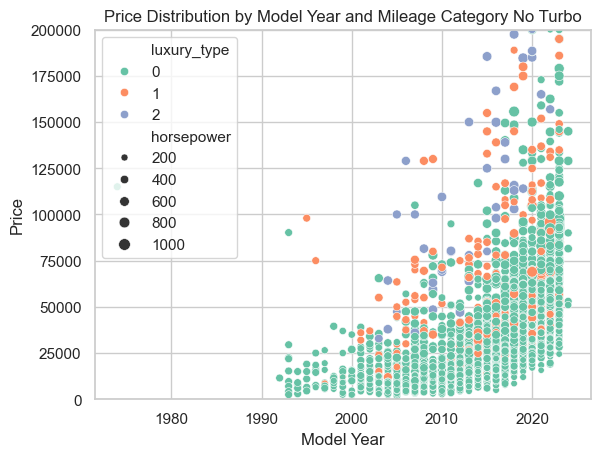

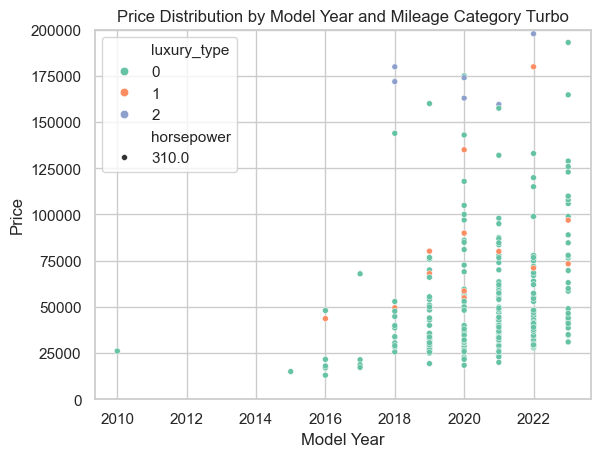

In [85]:


# Create the boxplot
sns.scatterplot(x='model_year', y='price', hue='luxury_type', size="horsepower", data=origina_format[origina_format["turbo"] == 0], palette="Set2")


# Add titles and labels
plt.title('Price Distribution by Model Year and Mileage Category No Turbo')
plt.xlabel('Model Year')
plt.ylabel('Price')
plt.ylim(0,200000)
plt.show()

# Create the boxplot
sns.scatterplot(x='model_year', y='price', hue='luxury_type', size="horsepower", data=origina_format[origina_format["turbo"] == 1], palette="Set2")


# Add titles and labels
plt.title('Price Distribution by Model Year and Mileage Category Turbo')
plt.xlabel('Model Year')
plt.ylabel('Price')
plt.ylim(0,200000)
plt.show()


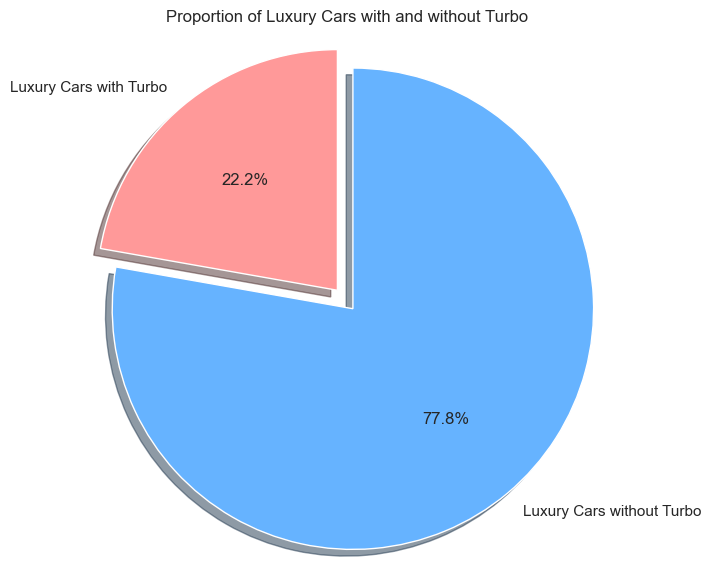

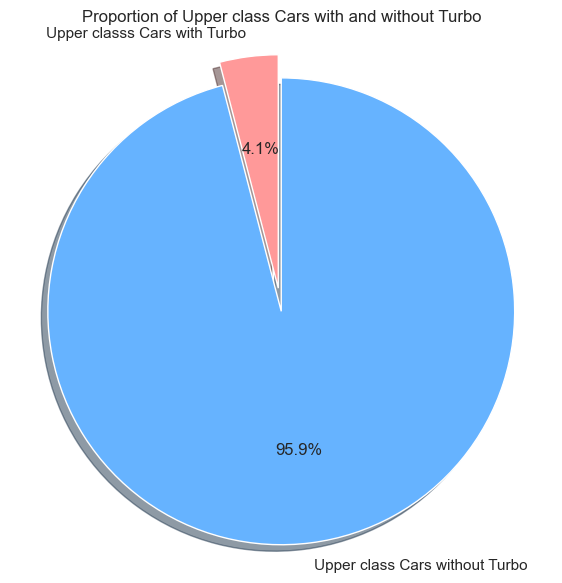

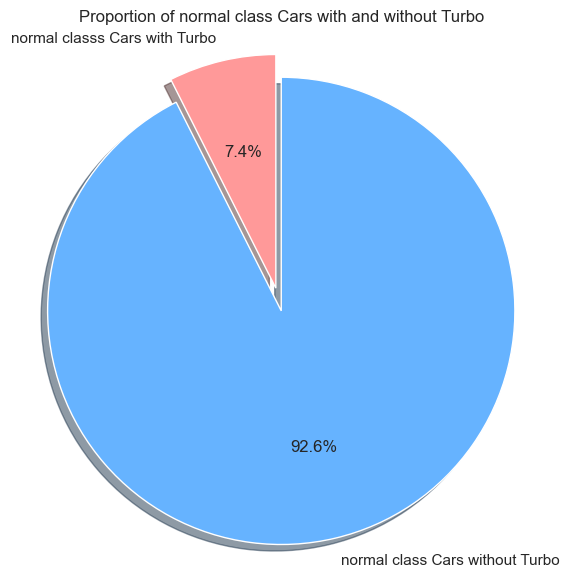

In [78]:
# Filter the data: Select only luxury cars containing turbo
luxury_turbo_cars = origina_format[(origina_format["Is_Luxury"] == 1) & (origina_format["turbo"] == 1)]

# Count the total number of luxury cars and the number of luxury cars with turbo
total_luxury_cars = origina_format[origina_format["Is_Luxury"] == 1]
luxury_with_turbo = len(luxury_turbo_cars)
luxury_without_turbo = len(total_luxury_cars) - luxury_with_turbo

# Data for the pie chart
labels = ['Luxury Cars with Turbo', 'Luxury Cars without Turbo']
sizes = [luxury_with_turbo, luxury_without_turbo]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # explode 1st slice (Luxury Cars with Turbo)

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode, shadow=True)
plt.title('Proportion of Luxury Cars with and without Turbo')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()
#####################################################################################################################################################################
# Filter the data: Select only luxury cars containing turbo
luxury_turbo_cars = origina_format[(origina_format["Is_Upper_class"] == 1) & (origina_format["turbo"] == 1)]

# Count the total number of luxury cars and the number of luxury cars with turbo
total_luxury_cars = origina_format[origina_format["Is_Upper_class"] == 1]
luxury_with_turbo = len(luxury_turbo_cars)
luxury_without_turbo = len(total_luxury_cars) - luxury_with_turbo

# Data for the pie chart
labels = ['Upper classs Cars with Turbo', 'Upper class Cars without Turbo']
sizes = [luxury_with_turbo, luxury_without_turbo]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # explode 1st slice (Luxury Cars with Turbo)

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode, shadow=True)
plt.title('Proportion of Upper class Cars with and without Turbo')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()

#####################################################################################################################################################################
# Filter the data: Select only luxury cars containing turbo
luxury_turbo_cars = origina_format[(origina_format["luxury_type"] == 0) & (origina_format["turbo"] == 1)]

# Count the total number of luxury cars and the number of luxury cars with turbo
total_luxury_cars = origina_format[origina_format["luxury_type"] == 0]
luxury_with_turbo = len(luxury_turbo_cars)
luxury_without_turbo = len(total_luxury_cars) - luxury_with_turbo

# Data for the pie chart
labels = ['normal classs Cars with Turbo', 'normal class Cars without Turbo']
sizes = [luxury_with_turbo, luxury_without_turbo]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # explode 1st slice (Luxury Cars with Turbo)

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode, shadow=True)
plt.title('Proportion of normal class Cars with and without Turbo')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()

Hypothesis: Int_Col has a surprising cor with price because expensive cars have a unique col (or unique color lead to more exp car). However, due to the scope of our paper we cannot examine what type of color is unique and if this leads to an more expensive car because the colors are too cryptic to differenitate it between expensive/unique color and normal. And for domain knowledge, we can assume that color doesnt have a signicifant impact on the price except if it is an extreme color like neon pink or so. However, due to the unlikehood of this being of higher importance than other essential factors like milage, HP or so, we wont conduct any further research on it.

In [83]:
print(len(origina_format["int_col"].unique()))
print(len(origina_format["ext_col"].unique()))

156
319
